# pulse_input_DDM choice model tutorial

`using` is the julia version of python's `import`, i.e. in incorporates the exported functions of a module into the current namespace. `Distributed` is a julia module for performing parallel computing. `addprocs()` adds some workers, which can be called by a main process if there are calls to do things in parallel. `pulse_input_DDM` parallelizes the computation of the log-likelhood across trials.

In [1]:
using Distributed
addprocs(44);

when `using` is called after workers have been made, i.e. above, then those modules are available on all the workers (i.e. any function called from those modules will be able to be executed on any worker)

In [2]:
using pulse_input_DDM, Flatten

create some parameters to generate data with

In [3]:
θ_generative = θchoice(θz=θz(σ2_i = 5., B = 8., λ = -1., σ2_a = 20., σ2_s = 0.5,
    ϕ = 0.8, τ_ϕ = 0.05), bias=2., lapse=0.05);

"flatten" them into a vector for easy use later

In [4]:
x_generative = collect(Flatten.flatten(θ_generative));

`pulse_input_DDM` computes the log-likelihood by propogating mass of the latent distribution in time. This is done numerically by dividing the distribution up into little temporal and spatial bins. `n` is the number of spatials bins to use. `n=53` seems to work well.

In [5]:
n, dt = 53, 1e-2

53

## Fit 50K trials

Generate some fake data using the above parameters, and then see if you can recover it from a few different initializations of the optimization

Define bounds for each parameter for the optimization. Some of these are strict (i.e. variance > 0) and some are not (B < 100 seems reasonable, but B could of course be larger then 100.)

In [6]:
lb = [0., 2.,  -5., 0.,   0.,  0., 0.005, -5.0, 0.0]
ub = [30., 100., 5., 200., 10., 1.2,  1., 5.0, 1.0];

generate 50K trials of fake data. change `rng` to get a different set with the same parameters. `dt` specifies the temporal binning of the data. `1e-2` has worked well.

In [7]:
_, data_50K = synthetic_data(n ;θ=θ_generative, ntrials=50_000, rng=1, dt=dt);

`fit` specifies which parameters should be learned. If they are not learned, they remain at their value from `x0`, the initial point of the optimization.

In [8]:
fit = vcat(trues(9));
x0 = vcat([0.1, 15., -0.1, 20.,  0.5, 0.2,  0.008], [0.,  0.01]);

wrap up the generative parameters and the data into the `choiceDDM` class

In [9]:
model = choiceDDM(θ=θ_generative, data=data_50K, n=n)

choiceDDM{θchoice{θz{Float64},Float64},Array{pulse_input_DDM.choicedata{pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}},1},θprior{Float64}}
  θ: θchoice{θz{Float64},Float64}
  data: Array{pulse_input_DDM.choicedata{pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}}}((50000,))
  n: Int64 53
  cross: Bool false
  θprior: θprior{Float64}


to see the docstring for `choiceDDM` type `?`

In [10]:
? choiceDDM

search: choiceDDM choiceDDM_dx neural_choiceDDM neural_choice_GLM_DDM



```
choiceDDM(θ, data, n, cross)
```

Fields:

  * `θ`: a instance of the module-defined class `θchoice` that contains all of the model parameters for a `choiceDDM`
  * `data`: an `array` where each entry is the module-defined class `choicedata`, which contains all of the data (inputs and choices).
  * `n`: number of spatial bins to use (defaults to 53).
  * `cross`: whether or not to use cross click adaptation (defaults to false).

Example:

```julia
ntrials, dt, centered, n  = 1, 1e-2, false, 53
θ = θchoice()
_, data = synthetic_data(n ;θ=θ, ntrials=ntrials, rng=1, dt=dt);
choiceDDM(θ=θ, data=data, n=n)
```


compute the log-likelihood of the generative data. results from optimization should be larger than this

In [11]:
loglikelihood(model)

-15412.664861670126

In [12]:
? choiceoptions

search: choiceoptions neural_choice_options HMMDDM_choice_options_2



```
choiceoptions(fit, lb, ub)
```

Fields:

  * `fit`: `array` of `Bool` for optimization for `choiceDDM` model.
  * `lb`: `array` of lower bounds for optimization for `choiceDDM` model.
  * `ub`: `array` of upper bounds for optimization for `choiceDDM` model.


In [13]:
options = choiceoptions(fit=fit, lb=lb, ub=ub)

choiceoptions
  fit: Array{Bool}((9,)) Bool[1, 1, 1, 1, 1, 1, 1, 1, 1]
  lb: Array{Float64}((9,)) [0.0, 2.0, -5.0, 0.0, 0.0, 0.0, 0.005, -5.0, 0.0]
  ub: Array{Float64}((9,)) [30.0, 100.0, 5.0, 200.0, 10.0, 1.2, 1.0, 5.0, 1.0]


example of how to optimize parameters given data

In [15]:
? optimize

search: optimize choice_optimize choice_neural_optimize



```
optimize(x, ll, lb, ub)
```

Wrapper for executing an constrained optimization.

Arguments:

  * `ll`: objective function.
  * `x`: an `array` of initial point
  * `lb`: lower bounds. `array` the same length as `x`.
  * `ub: upper bounds.`array`the same length as`x`.

---

```
optimize(model, options)
```

Optimize model parameters for a `choiceDDM`.

Returns:

  * `model`: an instance of a `choiceDDM`.
  * `output`: results from [`Optim.optimize`](@ref).

Arguments:

  * `model`: an instance of a `choiceDDM`.
  * `options`: module-defind type that contains the upper (`ub`) and lower (`lb`) boundaries and specification of which parameters to fit (`fit`).

---

```
optimize(data, options)
```

Optimize model parameters for a `choiceDDM`.

Returns:

  * `model`: an instance of a `choiceDDM`.
  * `output`: results from [`Optim.optimize`](@ref).

Arguments:

  * `data`: an `array`, each element of which is a module-defined type `choicedata`. `choicedata` contains the click data and the choice for a trial.
  * `options`: module-defind type that contains the upper (`ub`) and lower (`lb`) boundaries and specification of which parameters to fit (`fit`).

---

```
optimize(model, options)
```

Optimize model parameters for a `choiceDDM`.

Returns:

  * `model`: an instance of a `choiceDDM_dx`.
  * `output`: results from [`Optim.optimize`](@ref).

Arguments:

  * `model`: an instance of a `choiceDDM_dx`.
  * `options`: module-defind type that contains the upper (`ub`) and lower (`lb`) boundaries and specification of which parameters to fit (`fit`).

---

```
optimize(model, options)
```

Optimize model parameters for a `HMMDDM_choice_2`.

Arguments: 

  * `model`: an instance of a `HMMDDM_choice_2`.
  * `options`: some details related to the optimzation, such as which parameters were fit (`fit`), and the upper (`ub`) and lower (`lb`) bounds of those parameters.

Returns:

  * `model`: an instance of a `HMMDDM_choice_2`.
  * `output`: results from [`Optim.optimize`](@ref).

---

```
optimize(data, f)
```

Optimize model parameters for a `neuralDDM`. Neural tuning parameters ([`θy`](@ref)) are initialized by fitting a the noiseless DDM model first ([`noiseless_neuralDDM`](@ref)).

Arguments:

  * `data`: the output of [`load_neural_data`](@ref) with the format as described in its docstring.
  * `f`: an `array` of length number of sessions, where each subarray is length number of cells. Each entry is a string, either `Softplus` or `Sigmoid` to describe the nonlinear map between $a(t)$ and $\lambda(a)$, the expected firing rate.

Returns

  * `model`: a module-defined type that organizes the `data` and parameters from the fit (as well as a few other things that are necessary for re-computing things the way they were computed here (e.g. `n`)
  * `options`: some details related to the optimzation, such as which parameters were fit, and the upper and lower bounds of those parameters.

---

```
optimize(model, options)
```

Optimize model parameters for a `neuralDDM`.

Arguments: 

  * `model`: an instance of a `neuralDDM`.
  * `options`: some details related to the optimzation, such as which parameters were fit (`fit`), and the upper (`ub`) and lower (`lb`) bounds of those parameters.

Returns:

  * `model`: an instance of a `neuralDDM`.
  * `output`: results from [`Optim.optimize`](@ref).

---

```
optimize(model, options)
```

Optimize model parameters for a `noiseless_neuralDDM`.

Arguments: 

  * `model`: an instance of a `noiseless_neuralDDM`.
  * `options`: some details related to the optimzation, such as which parameters were fit (`fit`), and the upper (`ub`) and lower (`lb`) bounds of those parameters.

Returns:

  * `model`: an instance of a `noiseless_neuralDDM`.
  * `output`: results from [`Optim.optimize`](@ref).

---

```
optimize(model, options)
```

Optimize model parameters for a `HMMDDM`.

Arguments: 

  * `model`: an instance of a `HMMDDM`.
  * `options`: some details related to the optimzation, such as which parameters were fit (`fit`), and the upper (`ub`) and lower (`lb`) bounds of those parameters.

Returns:

  * `model`: an instance of a `HMMDDM`.
  * `output`: results from [`Optim.optimize`](@ref).

---

```
optimize(model, options)
```

Optimize model parameters for a `neural_choice_GLM_DDM`.

Arguments: 

  * `model`: an instance of a `neural_choice_GLM_DDM`.
  * `options`: some details related to the optimzation, such as which parameters were fit (`fit`), and the upper (`ub`) and lower (`lb`) bounds of those parameters.

Returns:

  * `model`: an instance of a `neural_choice_GLM_DDM`.
  * `output`: results from [`Optim.optimize`](@ref).

---

```
optimize(model, options)
```

Optimize model parameters for a `HMMDDM_joint`.

Arguments: 

  * `model`: an instance of a `HMMDDM_joint`.
  * `options`: some details related to the optimzation, such as which parameters were fit (`fit`), and the upper (`ub`) and lower (`lb`) bounds of those parameters.

Returns:

  * `model`: an instance of a `HMMDDM_joint`.
  * `output`: results from [`Optim.optimize`](@ref).

---

```
optimize(model, options)
```

Optimize model parameters for a `HMMDDM_joint_2`.

Arguments: 

  * `model`: an instance of a `HMMDDM_joint_2`.
  * `options`: some details related to the optimzation, such as which parameters were fit (`fit`), and the upper (`ub`) and lower (`lb`) bounds of those parameters.

Returns:

  * `model`: an instance of a `HMMDDM_joint_2`.
  * `output`: results from [`Optim.optimize`](@ref).

---

```
optimize(model, options)
```

Optimize model parameters for a `HMMDDM_joint_3`.

Arguments: 

  * `model`: an instance of a `HMMDDM_joint_3`.
  * `options`: some details related to the optimzation, such as which parameters were fit (`fit`), and the upper (`ub`) and lower (`lb`) bounds of those parameters.

Returns:

  * `model`: an instance of a `HMMDDM_joint_3`.
  * `output`: results from [`Optim.optimize`](@ref).


In [16]:
model, = optimize(data_50K, options; x0=x0, iterations=1, outer_iterations=1)

Fminbox
-------
Initial mu = 0.680509

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.680509

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     1.806971e+04     2.315714e+05
 * time: 7.081031799316406e-5

Exiting inner optimizer with x = [0.10000863210908935, 15.000003385819976, -0.10001126118833825, 20.0000042646091, 0.5002497109925105, 0.19982850145901143, 0.028003612232093827, 8.348612502298714e-5, 0.016203361804739375]
Current distance to box: 0.0162034
Decreasing barrier term μ.



(choiceDDM{θchoice{θz{Float64},Float64},Array{pulse_input_DDM.choicedata{pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}},1},θprior{Float64}}
  θ: θchoice{θz{Float64},Float64}
  data: Array{pulse_input_DDM.choicedata{pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}}}((50000,))
  n: Int64 53
  cross: Bool false
  θprior: θprior{Float64}
,  * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [1.00e-01, 1.50e+01, -1.00e-01,  ...]
    Minimum:   1.681859e+04

 * Found with
    Algorithm:     Fminbox with BFGS
    Initial Point: [1.00e-01, 1.50e+01, -1.00e-01,  ...]

 * Convergence measures
    |x - x'|               = 2.09e-02 ≰ 1.0e-10
    |x - x'|/|x'|          = 8.38e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.26e+03 ≰ 1.0e-09
    |f(x) - f(x')|/|f(x')| = 7.50e-02 ≰ 0.0e+00
    |g(x)|                 = 5.03e+04 ≰ 1.0e-03

 * Work counters
    Seconds run:   246  (vs limit 170

In [21]:
import pulse_input_DDM: transition_M, bins

In [22]:
xc, dx = bins(θ_generative.θz.B, n)

([-8.156862745098039, -7.8431372549019605, -7.529411764705882, -7.215686274509804, -6.901960784313726, -6.588235294117647, -6.2745098039215685, -5.96078431372549, -5.647058823529412, -5.333333333333333  …  5.333333333333333, 5.647058823529412, 5.96078431372549, 6.2745098039215685, 6.588235294117647, 6.901960784313726, 7.215686274509804, 7.529411764705882, 7.8431372549019605, 8.156862745098039], 0.3137254901960784)

In [31]:
? transition_M

search: transition_M



```
transition_M(σ2, λ, μ, dx, xc, n, dt)
```

Returns a $n \times n$ Markov transition matrix. The transition matrix is discrete approximation to the Fokker-Planck equation with drift λ, diffusion σ2 and driving current (i.e. click input) μ. dx and dt define the spatial and temporal binning, respectively. xc are the bin center locations.

See also: [`transition_M!`](@ref)

### Examples

```jldoctest
julia> dt, n, B, σ2, λ, μ = 0.1, 53, 10., 10., -0.5, 1.;

julia> xc,dx = pulse_input_DDM.bins(B, n);

julia> M = pulse_input_DDM.transition_M(σ2, λ, μ, dx, xc, n, dt);

julia> size(M)
(53, 53)
```


In [30]:
M = transition_M(θ_generative.θz.σ2_a, θ_generative.θz.λ, 0., dx, xc, n, dt)

53×53 Array{Float64,2}:
 1.0  0.47906      0.45147      0.424112     …  0.000274848  0.000211913  0.0
 0.0  0.0279689    0.0278678    0.0276336       8.09237e-5   6.36733e-5   0.0
 0.0  0.0279343    0.0279692    0.0278695       0.0001026    8.11225e-5   0.0
 0.0  0.027763     0.0279333    0.0279695       0.000129444  0.000102846  0.0
 0.0  0.0274574    0.0277607    0.0279323       0.000162509  0.000129748  0.0
 0.0  0.027022     0.0274538    0.0277583    …  0.00020302   0.000162882  0.0
 0.0  0.0264631    0.0270171    0.0274501       0.000252385  0.000203475  0.0
 0.0  0.0257886    0.026457     0.0270122       0.000312214  0.000252938  0.0
 0.0  0.0250081    0.0257815    0.0264509       0.00038433   0.000312881  0.0
 0.0  0.0241323    0.0249999    0.0257743       0.000470782  0.00038513   0.0
 0.0  0.0231729    0.0241232    0.0249917    …  0.00057385   0.000471737  0.0
 0.0  0.0221425    0.0231631    0.0241141       0.000696052  0.000574985  0.0
 0.0  0.0210542    0.022132     0.023153

In [32]:
using PyPlot

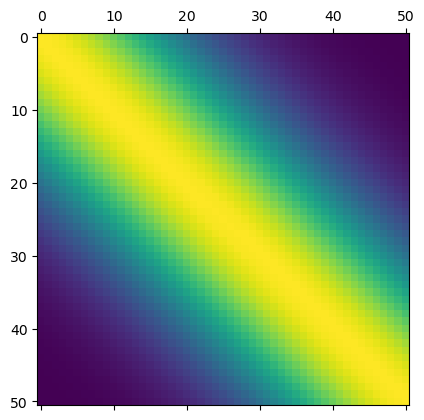

PyObject <matplotlib.image.AxesImage object at 0x7f9f74094908>

In [34]:
matshow(M[2:end-1, 2:end-1])